In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn import metrics
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from IPython.display import HTML
import json
import altair as alt

import networkx as nx

In [2]:
import os
import time
import datetime
import json
import gc
from numba import jit

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn import metrics

from itertools import product

import altair as alt
#from altair.vega import v5
from IPython.display import HTML

# using ideas from this kernel: https://www.kaggle.com/notslush/altair-visualization-2018-stackoverflow-survey
def prepare_altair():
    """
    Helper function to prepare altair for working.
    """

    vega_url = 'https://cdn.jsdelivr.net/npm/vega@' + v5.SCHEMA_VERSION
    vega_lib_url = 'https://cdn.jsdelivr.net/npm/vega-lib'
    vega_lite_url = 'https://cdn.jsdelivr.net/npm/vega-lite@' + alt.SCHEMA_VERSION
    vega_embed_url = 'https://cdn.jsdelivr.net/npm/vega-embed@3'
    noext = "?noext"
    
    paths = {
        'vega': vega_url + noext,
        'vega-lib': vega_lib_url + noext,
        'vega-lite': vega_lite_url + noext,
        'vega-embed': vega_embed_url + noext
    }
    
    workaround = f"""    requirejs.config({{
        baseUrl: 'https://cdn.jsdelivr.net/npm/',
        paths: {paths}
    }});
    """
    
    return workaround
    

def add_autoincrement(render_func):
    # Keep track of unique <div/> IDs
    cache = {}
    def wrapped(chart, id="vega-chart", autoincrement=True):
        if autoincrement:
            if id in cache:
                counter = 1 + cache[id]
                cache[id] = counter
            else:
                cache[id] = 0
            actual_id = id if cache[id] == 0 else id + '-' + str(cache[id])
        else:
            if id not in cache:
                cache[id] = 0
            actual_id = id
        return render_func(chart, id=actual_id)
    # Cache will stay outside and 
    return wrapped
           

@add_autoincrement
def render(chart, id="vega-chart"):
    """
    Helper function to plot altair visualizations.
    """
    chart_str = """
    <div id="{id}"></div><script>
    require(["vega-embed"], function(vg_embed) {{
        const spec = {chart};     
        vg_embed("#{id}", spec, {{defaultStyle: true}}).catch(console.warn);
        console.log("anything?");
    }});
    console.log("really...anything?");
    </script>
    """
    return HTML(
        chart_str.format(
            id=id,
            chart=json.dumps(chart) if isinstance(chart, dict) else chart.to_json(indent=None)
        )
    )
    

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            col_type
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                c_prec = df[col].apply(lambda x: np.finfo(x).precision).max()
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max and c_prec == np.finfo(np.float16).precision:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max and c_prec == np.finfo(np.float32).precision:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df
    

@jit
def fast_auc(y_true, y_prob):
    """
    fast roc_auc computation: https://www.kaggle.com/c/microsoft-malware-prediction/discussion/76013
    """
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    auc /= (nfalse * (n - nfalse))
    return auc


def eval_auc(y_true, y_pred):
    """
    Fast auc eval function for lgb.
    """
    return 'auc', fast_auc(y_true, y_pred), True


def group_mean_log_mae(y_true, y_pred, types, floor=1e-9):
    """
    Fast metric computation for this competition: https://www.kaggle.com/c/champs-scalar-coupling
    Code is from this kernel: https://www.kaggle.com/uberkinder/efficient-metric
    """
    maes = (y_true-y_pred).abs().groupby(types).mean()
    return np.log(maes.map(lambda x: max(x, floor))).mean()
    

def train_model_regression(X, X_test, y, params, folds, model_type='lgb', eval_metric='mae', columns=None, plot_feature_importance=False, model=None,
                               verbose=10000, early_stopping_rounds=200, n_estimators=50000):
    """
    A function to train a variety of regression models.
    Returns dictionary with oof predictions, test predictions, scores and, if necessary, feature importances.
    
    :params: X - training data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: X_test - test data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: y - target
    :params: folds - folds to split data
    :params: model_type - type of model to use
    :params: eval_metric - metric to use
    :params: columns - columns to use. If None - use all columns
    :params: plot_feature_importance - whether to plot feature importance of LGB
    :params: model - sklearn model, works only for "sklearn" model type
    
    """
    columns = X.columns if columns is None else columns
    X_test = X_test[columns]
    
    # to set up scoring parameters
    metrics_dict = {'mae': {'lgb_metric_name': 'mae',
                        'catboost_metric_name': 'MAE',
                        'sklearn_scoring_function': metrics.mean_absolute_error},
                    'group_mae': {'lgb_metric_name': 'mae',
                        'catboost_metric_name': 'MAE',
                        'scoring_function': group_mean_log_mae},
                    'mse': {'lgb_metric_name': 'mse',
                        'catboost_metric_name': 'MSE',
                        'sklearn_scoring_function': metrics.mean_squared_error}
                    }

    
    result_dict = {}
    
    # out-of-fold predictions on train data
    oof = np.zeros(len(X))
    
    # averaged predictions on train data
    prediction = np.zeros(len(X_test))
    
    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
    
    # split and train on folds
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = n_estimators, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
                    verbose=verbose, early_stopping_rounds=early_stopping_rounds)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=verbose, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid)
            print(f'Fold {fold_n}. {eval_metric}: {score:.4f}.')
            print('')
            
            y_pred = model.predict(X_test).reshape(-1,)
        
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric=metrics_dict[eval_metric]['catboost_metric_name'], **params,
                                      loss_function=metrics_dict[eval_metric]['catboost_metric_name'])
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        if eval_metric != 'group_mae':
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))
        else:
            scores.append(metrics_dict[eval_metric]['scoring_function'](y_valid, y_pred_valid, X_valid['type']))

        prediction += y_pred    
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= folds.n_splits
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= folds.n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
        
    return result_dict
    


def train_model_classification(X, X_test, y, params, folds, model_type='lgb', eval_metric='auc', columns=None, plot_feature_importance=False, model=None,
                               verbose=10000, early_stopping_rounds=200, n_estimators=50000):
    """
    A function to train a variety of regression models.
    Returns dictionary with oof predictions, test predictions, scores and, if necessary, feature importances.
    
    :params: X - training data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: X_test - test data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: y - target
    :params: folds - folds to split data
    :params: model_type - type of model to use
    :params: eval_metric - metric to use
    :params: columns - columns to use. If None - use all columns
    :params: plot_feature_importance - whether to plot feature importance of LGB
    :params: model - sklearn model, works only for "sklearn" model type
    
    """
    columns = X.columns if columns == None else columns
    X_test = X_test[columns]
    
    # to set up scoring parameters
    metrics_dict = {'auc': {'lgb_metric_name': eval_auc,
                        'catboost_metric_name': 'AUC',
                        'sklearn_scoring_function': metrics.roc_auc_score},
                    }
    
    result_dict = {}
    
    # out-of-fold predictions on train data
    oof = np.zeros((len(X), len(set(y.values))))
    
    # averaged predictions on train data
    prediction = np.zeros((len(X_test), oof.shape[1]))
    
    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
    
    # split and train on folds
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        if model_type == 'lgb':
            model = lgb.LGBMClassifier(**params, n_estimators=n_estimators, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
                    verbose=verbose, early_stopping_rounds=early_stopping_rounds)
            
            y_pred_valid = model.predict_proba(X_valid)
            y_pred = model.predict_proba(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=n_estimators, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=verbose, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid)
            print(f'Fold {fold_n}. {eval_metric}: {score:.4f}.')
            print('')
            
            y_pred = model.predict_proba(X_test)
        
        if model_type == 'cat':
            model = CatBoostClassifier(iterations=n_estimators, eval_metric=metrics_dict[eval_metric]['catboost_metric_name'], **params,
                                      loss_function=metrics_dict[eval_metric]['catboost_metric_name'])
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid
        scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid[:, 1]))

        prediction += y_pred    
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= folds.n_splits
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= folds.n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
        
    return result_dict

# setting up altair
#workaround = prepare_altair()
#HTML("".join((
#    "<script>",
#    workaround,
#    "</script>",
#)))

In [3]:
file_folder = '../champs-scalar-coupling'
train = pd.read_csv(f'{file_folder}/train.csv')
test = pd.read_csv(f'{file_folder}/test.csv')
sub = pd.read_csv(f'{file_folder}/sample_submission.csv')
structures = pd.read_csv(f'{file_folder}/structures.csv')
potential_energy = pd.read_csv(f'{file_folder}/potential_energy.csv')
mulliken_charges = pd.read_csv(f'{file_folder}/mulliken_charges.csv')
scalar_coupling_contributions = pd.read_csv(f'{file_folder}/scalar_coupling_contributions.csv')
magnetic_shielding_tensors = pd.read_csv(f'{file_folder}/magnetic_shielding_tensors.csv')
dipole_moments = pd.read_csv(f'{file_folder}/dipole_moments.csv')

In [81]:
scalar_coupling_contributions.head()



,molecule_name,atom_index_0,atom_index_1,type,fc,sd,pso,dso
0,dsgdb9nsd_000001,1,0,1JHC,83.022400000000005,0.254579,1.25862,0.272010
1,dsgdb9nsd_000001,1,2,2JHH,-11.034700000000001,0.352978,2.85839,-3.433600
2,dsgdb9nsd_000001,1,3,2JHH,-11.032500000000001,0.352944,2.85852,-3.433870
3,dsgdb9nsd_000001,1,4,2JHH,-11.031900000000000,0.352934,2.85855,-3.433930
4,dsgdb9nsd_000001,2,0,1JHC,83.022199999999998,0.254585,1.25861,0.272013


In [5]:
scalar_coupling_contributions.shape


(4659076, 8)

In [6]:
train.shape

(4659076, 6)

In [7]:
train = pd.merge(train, scalar_coupling_contributions, how = 'left',
                  left_on  = ['molecule_name', 'atom_index_0', 'atom_index_1', 'type'],
                  right_on = ['molecule_name', 'atom_index_0', 'atom_index_1', 'type'])
train=train[:50000]
test=test[:30000]
sub=sub[:30000]

In [8]:
train.shape

(50000, 10)

In [9]:
train.columns  

Index(['id', 'molecule_name', 'atom_index_0', 'atom_index_1', 'type',
       'scalar_coupling_constant', 'fc', 'sd', 'pso', 'dso'],
      dtype='object')

[0 3 1 4 2 6 5 7]


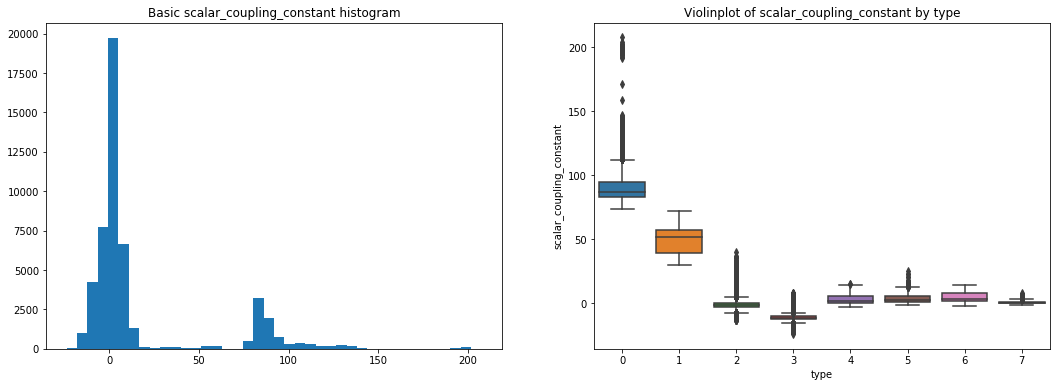

In [83]:
fig, ax = plt.subplots(figsize = (18, 6))
plt.subplot(1, 2, 1);
plt.hist(train['scalar_coupling_constant'], bins=40);
plt.title('Basic scalar_coupling_constant histogram');
plt.subplot(1, 2, 2);
sns.boxplot(x='type', y='scalar_coupling_constant', data=train);
plt.title('Violinplot of scalar_coupling_constant by type');

print(train['type'].unique())

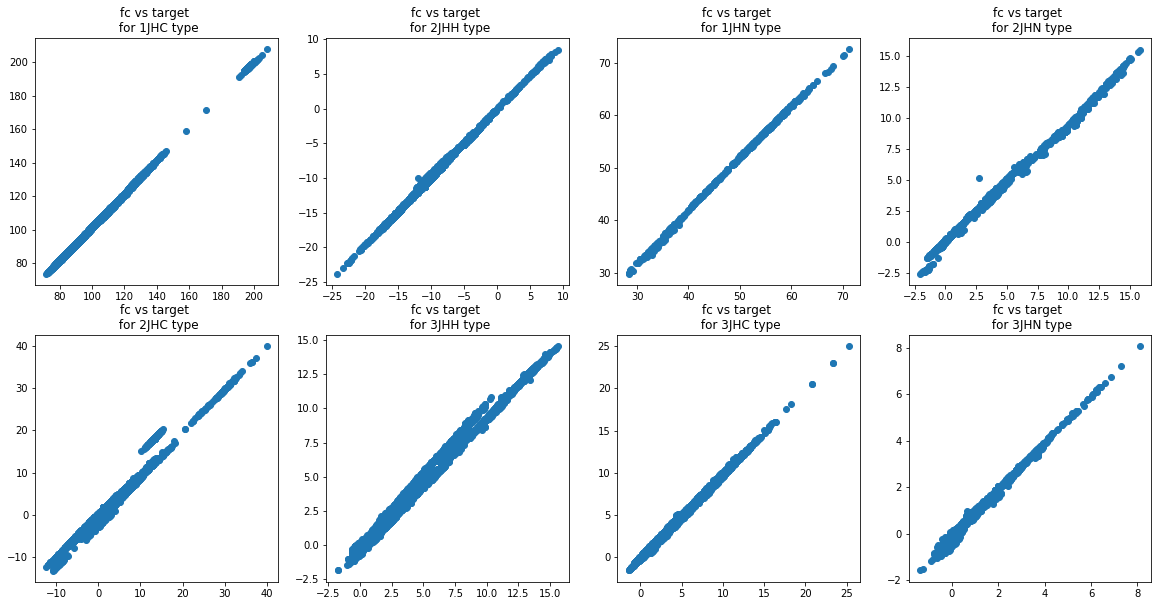

In [10]:
fig, ax = plt.subplots(figsize = (20, 10))
for i, t in enumerate(train['type'].unique()):
    plt.subplot(2, 4, i + 1);
    plt.scatter(train.loc[train['type'] == t, 'fc'], train.loc[train['type'] == t, 'scalar_coupling_constant'], label=t);
    plt.title(f'fc vs target \n for {t} type');

In [11]:
def map_atom_info(df, atom_idx):
    df = pd.merge(df, structures, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    return df

train = map_atom_info(train, 0)
train = map_atom_info(train, 1)

test = map_atom_info(test, 0)
test = map_atom_info(test, 1)

train_p_0 = train[['x_0', 'y_0', 'z_0']].values
train_p_1 = train[['x_1', 'y_1', 'z_1']].values
test_p_0 = test[['x_0', 'y_0', 'z_0']].values
test_p_1 = test[['x_1', 'y_1', 'z_1']].values

train['dist'] = np.linalg.norm(train_p_0 - train_p_1, axis=1)
test['dist'] = np.linalg.norm(test_p_0 - test_p_1, axis=1)
train['dist_x'] = (train['x_0'] - train['x_1']) ** 2
test['dist_x'] = (test['x_0'] - test['x_1']) ** 2
train['dist_y'] = (train['y_0'] - train['y_1']) ** 2
test['dist_y'] = (test['y_0'] - test['y_1']) ** 2
train['dist_z'] = (train['z_0'] - train['z_1']) ** 2
test['dist_z'] = (test['z_0'] - test['z_1']) ** 2

train['type_0'] = train['type'].apply(lambda x: x[0])
test['type_0'] = test['type'].apply(lambda x: x[0])

train = reduce_mem_usage(train)
test = reduce_mem_usage(test)


def create_features(df):
    df['molecule_couples'] = df.groupby('molecule_name')['id'].transform('count')
    df['molecule_dist_mean'] = df.groupby('molecule_name')['dist'].transform('mean')
    df['molecule_dist_min'] = df.groupby('molecule_name')['dist'].transform('min')
    df['molecule_dist_max'] = df.groupby('molecule_name')['dist'].transform('max')
    df['atom_0_couples_count'] = df.groupby(['molecule_name', 'atom_index_0'])['id'].transform('count')
    df['atom_1_couples_count'] = df.groupby(['molecule_name', 'atom_index_1'])['id'].transform('count')
    
    df[f'molecule_atom_index_0_x_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['x_1'].transform('std')
    df[f'molecule_atom_index_0_y_1_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('mean')
    df[f'molecule_atom_index_0_y_1_mean_diff'] = df[f'molecule_atom_index_0_y_1_mean'] - df['y_1']
    df[f'molecule_atom_index_0_y_1_mean_div'] = df[f'molecule_atom_index_0_y_1_mean'] / df['y_1']
    df[f'molecule_atom_index_0_y_1_max'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('max')
    df[f'molecule_atom_index_0_y_1_max_diff'] = df[f'molecule_atom_index_0_y_1_max'] - df['y_1']
    df[f'molecule_atom_index_0_y_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('std')
    df[f'molecule_atom_index_0_z_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['z_1'].transform('std')
    df[f'molecule_atom_index_0_dist_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('mean')
    df[f'molecule_atom_index_0_dist_mean_diff'] = df[f'molecule_atom_index_0_dist_mean'] - df['dist']
    df[f'molecule_atom_index_0_dist_mean_div'] = df[f'molecule_atom_index_0_dist_mean'] / df['dist']
    df[f'molecule_atom_index_0_dist_max'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('max')
    df[f'molecule_atom_index_0_dist_max_diff'] = df[f'molecule_atom_index_0_dist_max'] - df['dist']
    df[f'molecule_atom_index_0_dist_max_div'] = df[f'molecule_atom_index_0_dist_max'] / df['dist']
    df[f'molecule_atom_index_0_dist_min'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('min')
    df[f'molecule_atom_index_0_dist_min_diff'] = df[f'molecule_atom_index_0_dist_min'] - df['dist']
    df[f'molecule_atom_index_0_dist_min_div'] = df[f'molecule_atom_index_0_dist_min'] / df['dist']
    df[f'molecule_atom_index_0_dist_std'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('std')
    df[f'molecule_atom_index_0_dist_std_diff'] = df[f'molecule_atom_index_0_dist_std'] - df['dist']
    df[f'molecule_atom_index_0_dist_std_div'] = df[f'molecule_atom_index_0_dist_std'] / df['dist']
    df[f'molecule_atom_index_1_dist_mean'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('mean')
    df[f'molecule_atom_index_1_dist_mean_diff'] = df[f'molecule_atom_index_1_dist_mean'] - df['dist']
    df[f'molecule_atom_index_1_dist_mean_div'] = df[f'molecule_atom_index_1_dist_mean'] / df['dist']
    df[f'molecule_atom_index_1_dist_max'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('max')
    df[f'molecule_atom_index_1_dist_max_diff'] = df[f'molecule_atom_index_1_dist_max'] - df['dist']
    df[f'molecule_atom_index_1_dist_max_div'] = df[f'molecule_atom_index_1_dist_max'] / df['dist']
    df[f'molecule_atom_index_1_dist_min'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('min')
    df[f'molecule_atom_index_1_dist_min_diff'] = df[f'molecule_atom_index_1_dist_min'] - df['dist']
    df[f'molecule_atom_index_1_dist_min_div'] = df[f'molecule_atom_index_1_dist_min'] / df['dist']
    df[f'molecule_atom_index_1_dist_std'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('std')
    df[f'molecule_atom_index_1_dist_std_diff'] = df[f'molecule_atom_index_1_dist_std'] - df['dist']
    df[f'molecule_atom_index_1_dist_std_div'] = df[f'molecule_atom_index_1_dist_std'] / df['dist']
    df[f'molecule_atom_1_dist_mean'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('mean')
    df[f'molecule_atom_1_dist_min'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('min')
    df[f'molecule_atom_1_dist_min_diff'] = df[f'molecule_atom_1_dist_min'] - df['dist']
    df[f'molecule_atom_1_dist_min_div'] = df[f'molecule_atom_1_dist_min'] / df['dist']
    df[f'molecule_atom_1_dist_std'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('std')
    df[f'molecule_atom_1_dist_std_diff'] = df[f'molecule_atom_1_dist_std'] - df['dist']
    df[f'molecule_type_0_dist_std'] = df.groupby(['molecule_name', 'type_0'])['dist'].transform('std')
    df[f'molecule_type_0_dist_std_diff'] = df[f'molecule_type_0_dist_std'] - df['dist']
    df[f'molecule_type_dist_mean'] = df.groupby(['molecule_name', 'type'])['dist'].transform('mean')
    df[f'molecule_type_dist_mean_diff'] = df[f'molecule_type_dist_mean'] - df['dist']
    df[f'molecule_type_dist_mean_div'] = df[f'molecule_type_dist_mean'] / df['dist']
    df[f'molecule_type_dist_max'] = df.groupby(['molecule_name', 'type'])['dist'].transform('max')
    df[f'molecule_type_dist_min'] = df.groupby(['molecule_name', 'type'])['dist'].transform('min')
    df[f'molecule_type_dist_std'] = df.groupby(['molecule_name', 'type'])['dist'].transform('std')
    df[f'molecule_type_dist_std_diff'] = df[f'molecule_type_dist_std'] - df['dist']

    df = reduce_mem_usage(df)
    return df

train = create_features(train)
test = create_features(test)

good_columns = [
'molecule_atom_index_0_dist_min',
'molecule_atom_index_0_dist_max',
'molecule_atom_index_1_dist_min',
'molecule_atom_index_0_dist_mean',
'molecule_atom_index_0_dist_std',
'dist',
'molecule_atom_index_1_dist_std',
'molecule_atom_index_1_dist_max',
'molecule_atom_index_1_dist_mean',
'molecule_atom_index_0_dist_max_diff',
'molecule_atom_index_0_dist_max_div',
'molecule_atom_index_0_dist_std_diff',
'molecule_atom_index_0_dist_std_div',
'atom_0_couples_count',
'molecule_atom_index_0_dist_min_div',
'molecule_atom_index_1_dist_std_diff',
'molecule_atom_index_0_dist_mean_div',
'atom_1_couples_count',
'molecule_atom_index_0_dist_mean_diff',
'molecule_couples',
'atom_index_1',
'molecule_dist_mean',
'molecule_atom_index_1_dist_max_diff',
'molecule_atom_index_0_y_1_std',
'molecule_atom_index_1_dist_mean_diff',
'molecule_atom_index_1_dist_std_div',
'molecule_atom_index_1_dist_mean_div',
'molecule_atom_index_1_dist_min_diff',
'molecule_atom_index_1_dist_min_div',
'molecule_atom_index_1_dist_max_div',
'molecule_atom_index_0_z_1_std',
'y_0',
'molecule_type_dist_std_diff',
'molecule_atom_1_dist_min_diff',
'molecule_atom_index_0_x_1_std',
'molecule_dist_min',
'molecule_atom_index_0_dist_min_diff',
'molecule_atom_index_0_y_1_mean_diff',
'molecule_type_dist_min',
'molecule_atom_1_dist_min_div',
'atom_index_0',
'molecule_dist_max',
'molecule_atom_1_dist_std_diff',
'molecule_type_dist_max',
'molecule_atom_index_0_y_1_max_diff',
'molecule_type_0_dist_std_diff',
'molecule_type_dist_mean_diff',
'molecule_atom_1_dist_mean',
'molecule_atom_index_0_y_1_mean_div',
'molecule_type_dist_mean_div',
'type']

for f in ['atom_1', 'type_0', 'type']:
    if f in good_columns:
        lbl = LabelEncoder()
        lbl.fit(list(train[f].values) + list(test[f].values))
        train[f] = lbl.transform(list(train[f].values))
        test[f] = lbl.transform(list(test[f].values))

Mem. usage decreased to  8.30 Mb (9.4% reduction)
Mem. usage decreased to  3.83 Mb (11.8% reduction)
Mem. usage decreased to 27.51 Mb (3.5% reduction)
Mem. usage decreased to 15.36 Mb (3.8% reduction)


In [12]:
X = train[good_columns].copy()
y = train['scalar_coupling_constant']
y_fc = train['fc']
X_test = test[good_columns].copy()

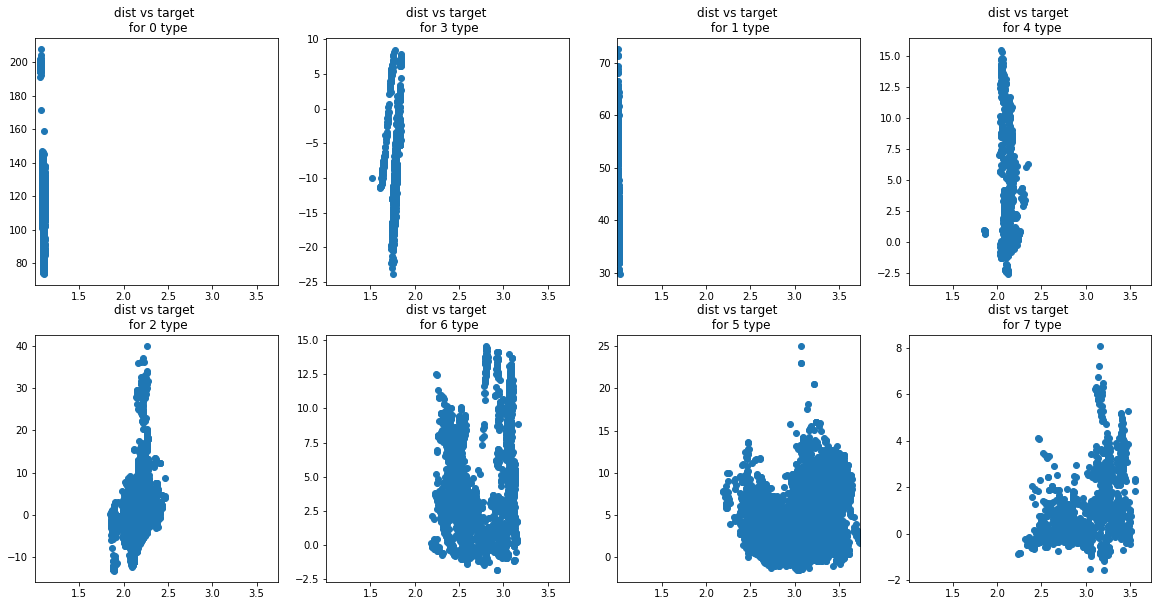

In [13]:
fig, ax = plt.subplots(figsize = (20, 10))
for i, t in enumerate(train['type'].unique()):
    plt.subplot(2, 4, i + 1);
    plt.scatter(train.loc[train['type'] == t, 'dist'], train.loc[train['type'] == t, 'scalar_coupling_constant'], label=t);
    plt.title(f'dist vs target \n for {t} type');
    plt.xlim(train['dist'].min(), train['dist'].max());

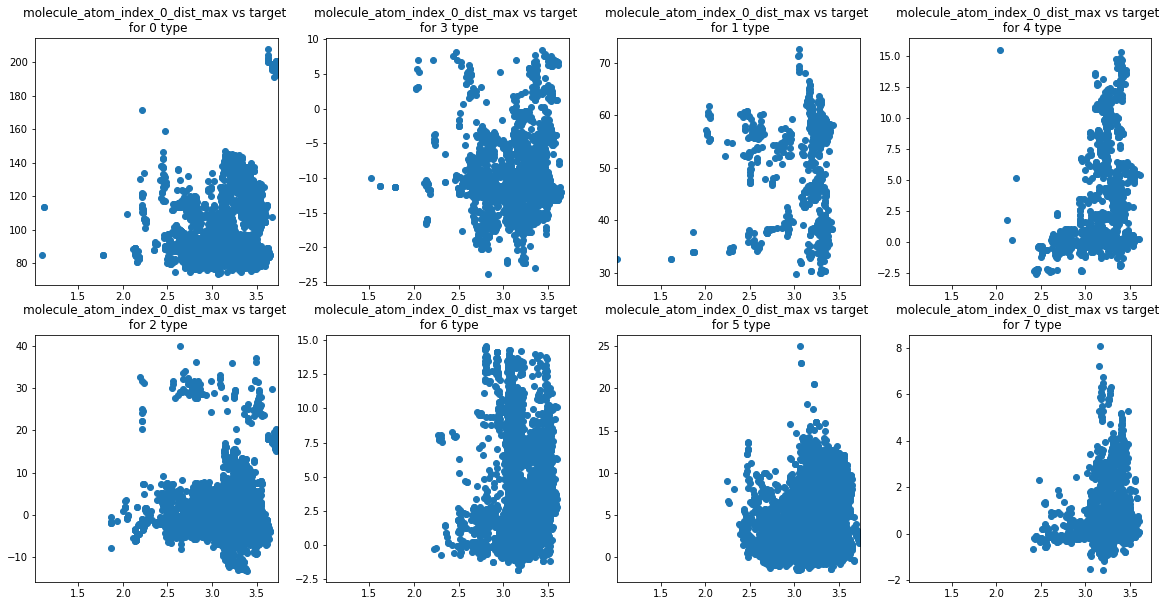

In [14]:
fig, ax = plt.subplots(figsize = (20, 10))
for i, t in enumerate(train['type'].unique()):
    plt.subplot(2, 4, i + 1);
    plt.scatter(train.loc[train['type'] == t, 'molecule_atom_index_0_dist_max'], train.loc[train['type'] == t, 'scalar_coupling_constant'], label=t);
    plt.title(f'molecule_atom_index_0_dist_max vs target \n for {t} type');
    plt.xlim(train['molecule_atom_index_0_dist_max'].min(), train['molecule_atom_index_0_dist_max'].max());

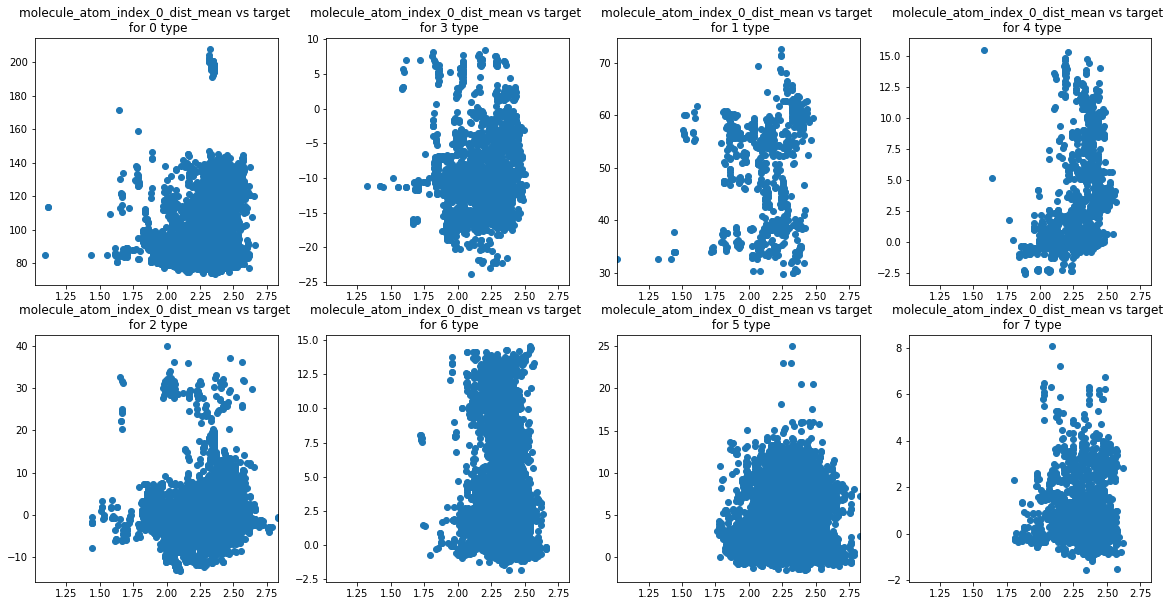

In [15]:
fig, ax = plt.subplots(figsize = (20, 10))
for i, t in enumerate(train['type'].unique()):
    plt.subplot(2, 4, i + 1);
    plt.scatter(train.loc[train['type'] == t, 'molecule_atom_index_0_dist_mean'], train.loc[train['type'] == t, 'scalar_coupling_constant'], label=t);
    plt.title(f'molecule_atom_index_0_dist_mean vs target \n for {t} type');
    plt.xlim(train['molecule_atom_index_0_dist_mean'].min(), train['molecule_atom_index_0_dist_mean'].max());

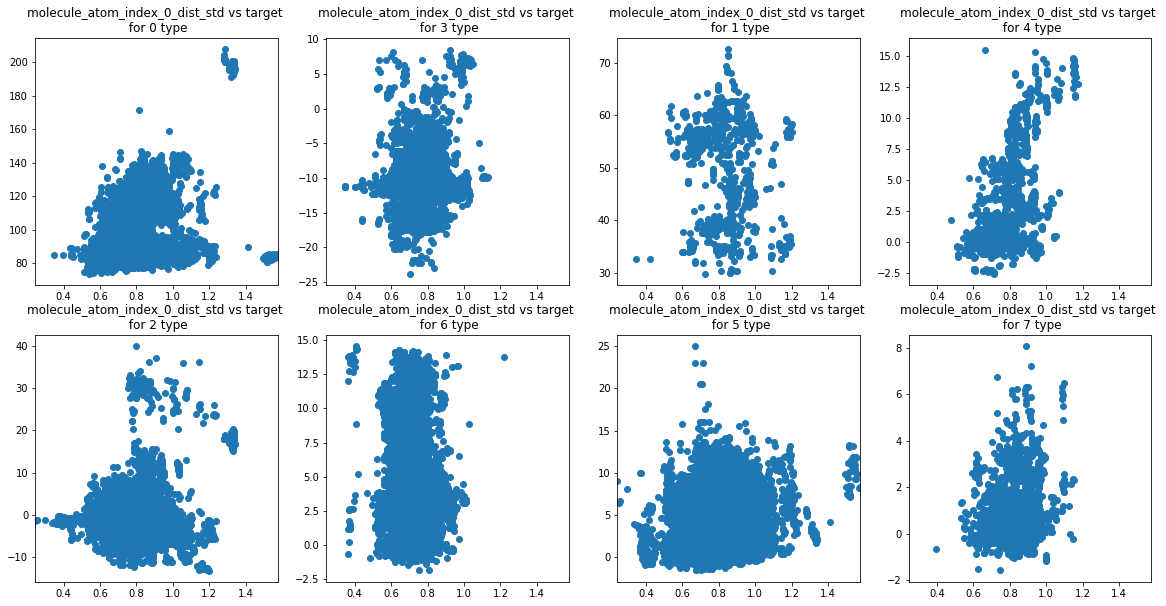

In [16]:
fig, ax = plt.subplots(figsize = (20, 10))
for i, t in enumerate(train['type'].unique()):
    plt.subplot(2, 4, i + 1);
    plt.scatter(train.loc[train['type'] == t, 'molecule_atom_index_0_dist_std'], train.loc[train['type'] == t, 'scalar_coupling_constant'], label=t);
    plt.title(f'molecule_atom_index_0_dist_std vs target \n for {t} type');
    plt.xlim(train['molecule_atom_index_0_dist_std'].min(), train['molecule_atom_index_0_dist_std'].max());

In [17]:
#del train, test
#gc.collect()

In [18]:
n_fold = 3
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)

In [19]:
train.shape

(50000, 76)

In [21]:
train.columns

Index(['id', 'molecule_name', 'atom_index_0', 'atom_index_1', 'type',
       'scalar_coupling_constant', 'fc', 'sd', 'pso', 'dso', 'atom_0', 'x_0',
       'y_0', 'z_0', 'atom_1', 'x_1', 'y_1', 'z_1', 'dist', 'dist_x', 'dist_y',
       'dist_z', 'type_0', 'molecule_couples', 'molecule_dist_mean',
       'molecule_dist_min', 'molecule_dist_max', 'atom_0_couples_count',
       'atom_1_couples_count', 'molecule_atom_index_0_x_1_std',
       'molecule_atom_index_0_y_1_mean', 'molecule_atom_index_0_y_1_mean_diff',
       'molecule_atom_index_0_y_1_mean_div', 'molecule_atom_index_0_y_1_max',
       'molecule_atom_index_0_y_1_max_diff', 'molecule_atom_index_0_y_1_std',
       'molecule_atom_index_0_z_1_std', 'molecule_atom_index_0_dist_mean',
       'molecule_atom_index_0_dist_mean_diff',
       'molecule_atom_index_0_dist_mean_div', 'molecule_atom_index_0_dist_max',
       'molecule_atom_index_0_dist_max_diff',
       'molecule_atom_index_0_dist_max_div', 'molecule_atom_index_0_dist_min',
   

Fold 1 started at Mon Mar 30 00:22:22 2020
Training until validation scores don't improve for 200 rounds
[500]	training's l1: 0.524815	valid_1's l1: 1.21689
[1000]	training's l1: 0.255262	valid_1's l1: 1.16514
[1500]	training's l1: 0.135708	valid_1's l1: 1.15188
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.135708	valid_1's l1: 1.15188
Fold 2 started at Mon Mar 30 00:22:50 2020
Training until validation scores don't improve for 200 rounds
[500]	training's l1: 0.510313	valid_1's l1: 1.17944
[1000]	training's l1: 0.247222	valid_1's l1: 1.13339
[1500]	training's l1: 0.128257	valid_1's l1: 1.1192
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.128257	valid_1's l1: 1.1192
Fold 3 started at Mon Mar 30 00:23:18 2020
Training until validation scores don't improve for 200 rounds
[500]	training's l1: 0.589505	valid_1's l1: 1.18647
[1000]	training's l1: 0.279997	valid_1's l1: 1.13005
[1500]	training's l1: 0.146923	valid_1's l1: 1.11352
Did not mee

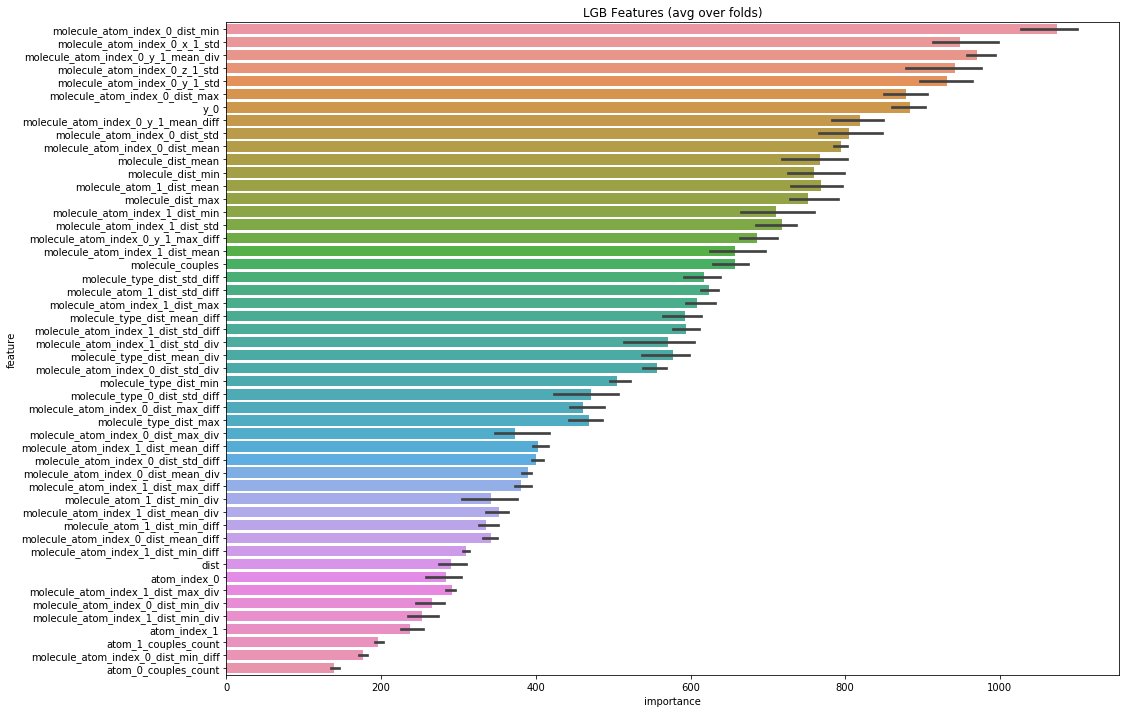

In [20]:
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }
result_dict_lgb = train_model_regression(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=True,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=1500)

Fold 1 started at Mon Mar 30 00:47:55 2020
Training until validation scores don't improve for 200 rounds
[500]	training's l1: 0.509336	valid_1's l1: 1.22278
[1000]	training's l1: 0.249612	valid_1's l1: 1.17181
[1500]	training's l1: 0.131131	valid_1's l1: 1.15622
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.131131	valid_1's l1: 1.15622
Fold 2 started at Mon Mar 30 00:48:23 2020
Training until validation scores don't improve for 200 rounds
[500]	training's l1: 0.509931	valid_1's l1: 1.18803
[1000]	training's l1: 0.246244	valid_1's l1: 1.14379
[1500]	training's l1: 0.129406	valid_1's l1: 1.13067
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.129406	valid_1's l1: 1.13067
Fold 3 started at Mon Mar 30 00:48:51 2020
Training until validation scores don't improve for 200 rounds
[500]	training's l1: 0.590397	valid_1's l1: 1.20515
[1000]	training's l1: 0.282073	valid_1's l1: 1.14373
[1500]	training's l1: 0.148428	valid_1's l1: 1.12593
Did not m

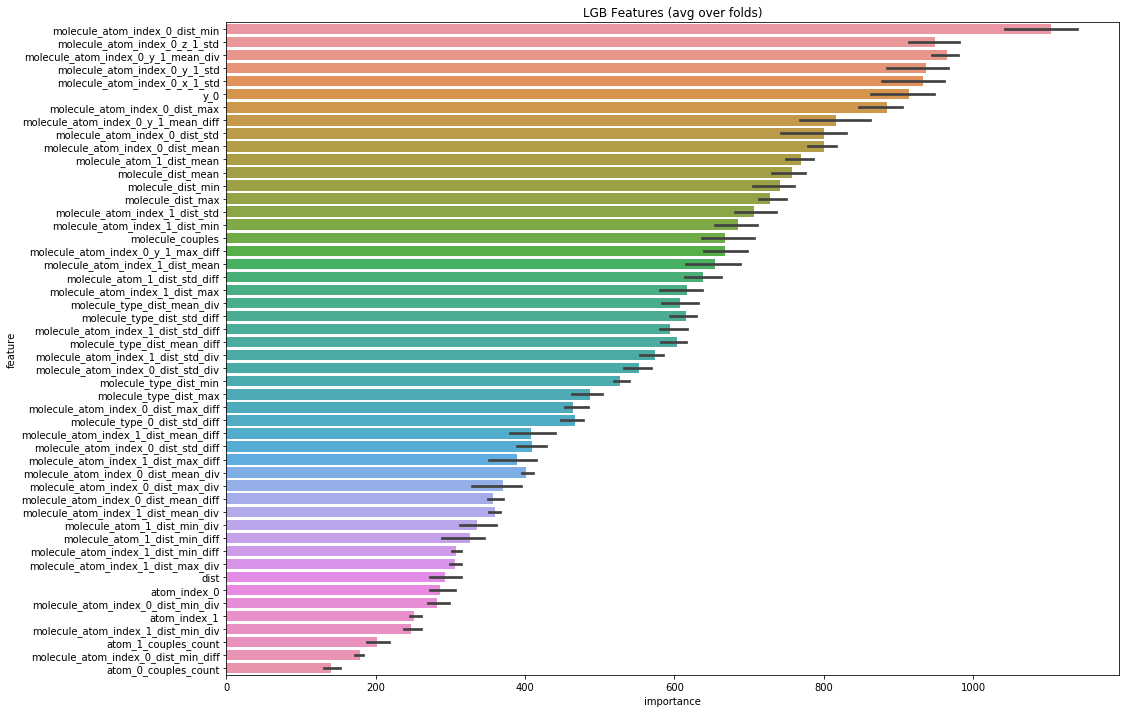

In [24]:
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }
result_dict_lgb_oof = train_model_regression(X=X, X_test=X_test, y=y_fc, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=True,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=1500)

In [44]:
X.shape

(50000, 52)

In [52]:
X.columns

Index(['molecule_atom_index_0_dist_min', 'molecule_atom_index_0_dist_max',
       'molecule_atom_index_1_dist_min', 'molecule_atom_index_0_dist_mean',
       'molecule_atom_index_0_dist_std', 'dist',
       'molecule_atom_index_1_dist_std', 'molecule_atom_index_1_dist_max',
       'molecule_atom_index_1_dist_mean',
       'molecule_atom_index_0_dist_max_diff',
       'molecule_atom_index_0_dist_max_div',
       'molecule_atom_index_0_dist_std_diff',
       'molecule_atom_index_0_dist_std_div', 'atom_0_couples_count',
       'molecule_atom_index_0_dist_min_div',
       'molecule_atom_index_1_dist_std_diff',
       'molecule_atom_index_0_dist_mean_div', 'atom_1_couples_count',
       'molecule_atom_index_0_dist_mean_diff', 'molecule_couples',
       'atom_index_1', 'molecule_dist_mean',
       'molecule_atom_index_1_dist_max_diff', 'molecule_atom_index_0_y_1_std',
       'molecule_atom_index_1_dist_mean_diff',
       'molecule_atom_index_1_dist_std_div',
       'molecule_atom_index_1_dis

In [48]:
X['oof_fc'] = result_dict_lgb_oof['oof']
X_test['oof_fc'] = result_dict_lgb_oof['prediction']

In [ ]:
X.shape

deeper Model with oof feature

Fold 1 started at Mon Mar 30 01:24:02 2020
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[33]	training's l1: 0.964867	valid_1's l1: 1.11756
Fold 2 started at Mon Mar 30 01:24:06 2020
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[38]	training's l1: 0.973171	valid_1's l1: 1.10076
Fold 3 started at Mon Mar 30 01:24:09 2020
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[35]	training's l1: 0.96389	valid_1's l1: 1.0992
CV mean score: 0.0528, std: 0.0051.


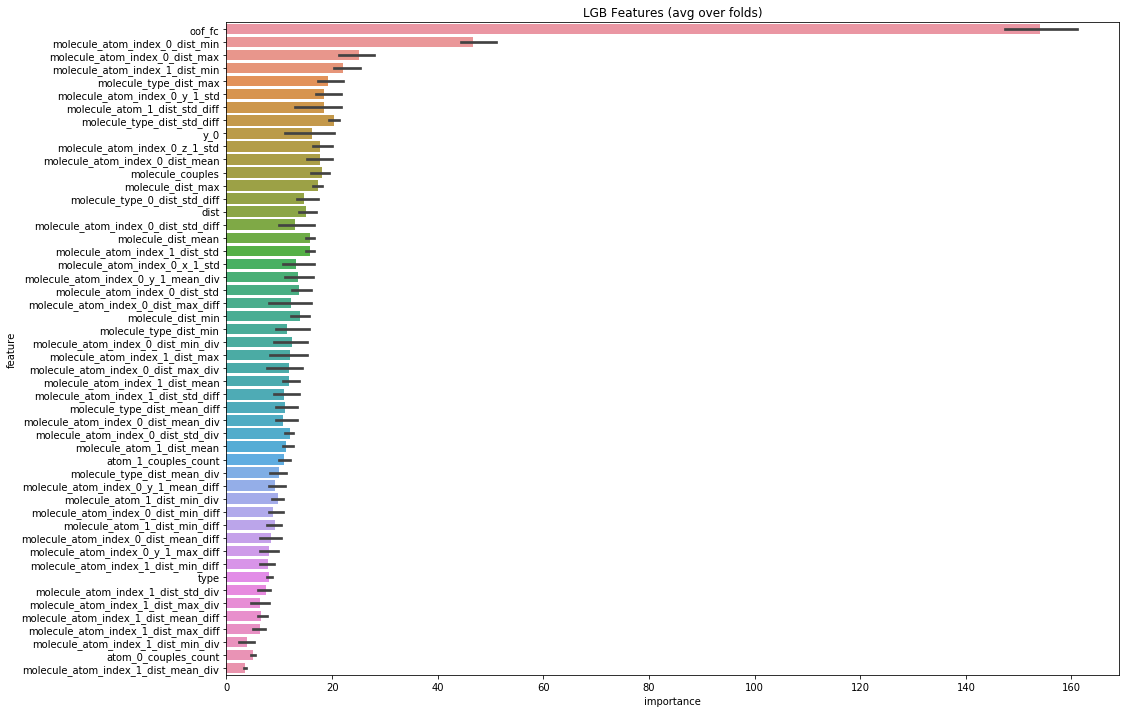

In [54]:
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }
result_dict_lgb2 = train_model_regression(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=True,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=1500)

Model with oof feature

Fold 1 started at Mon Mar 30 01:16:59 2020
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[28]	training's l1: 0.969794	valid_1's l1: 1.12734
Fold 2 started at Mon Mar 30 01:17:02 2020
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[23]	training's l1: 0.996811	valid_1's l1: 1.10694
Fold 3 started at Mon Mar 30 01:17:06 2020
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[22]	training's l1: 0.983416	valid_1's l1: 1.10352
CV mean score: 0.0592, std: 0.0056.


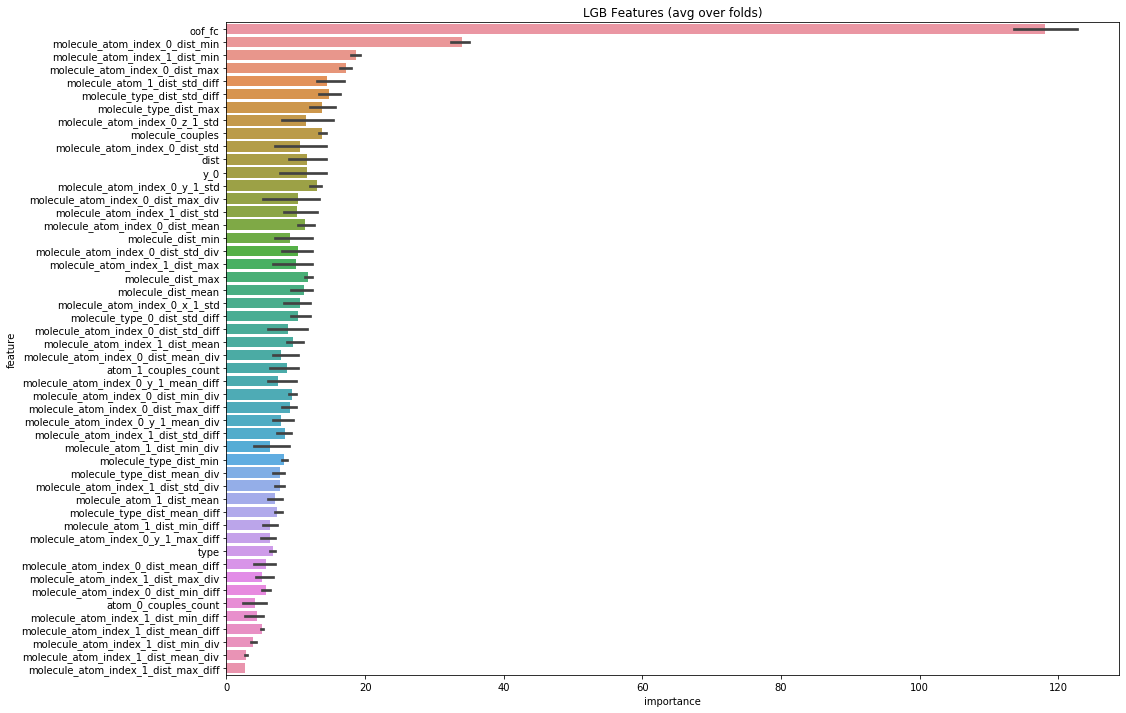

In [53]:
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.25,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }
result_dict_lgb2 = train_model_regression(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=True,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=3000)

In [84]:
sub['scalar_coupling_constant'] = result_dict_lgb2['prediction']
sub.to_csv('submission.csv', index=False)
sub.head()

ValueError: Length of values does not match length of index

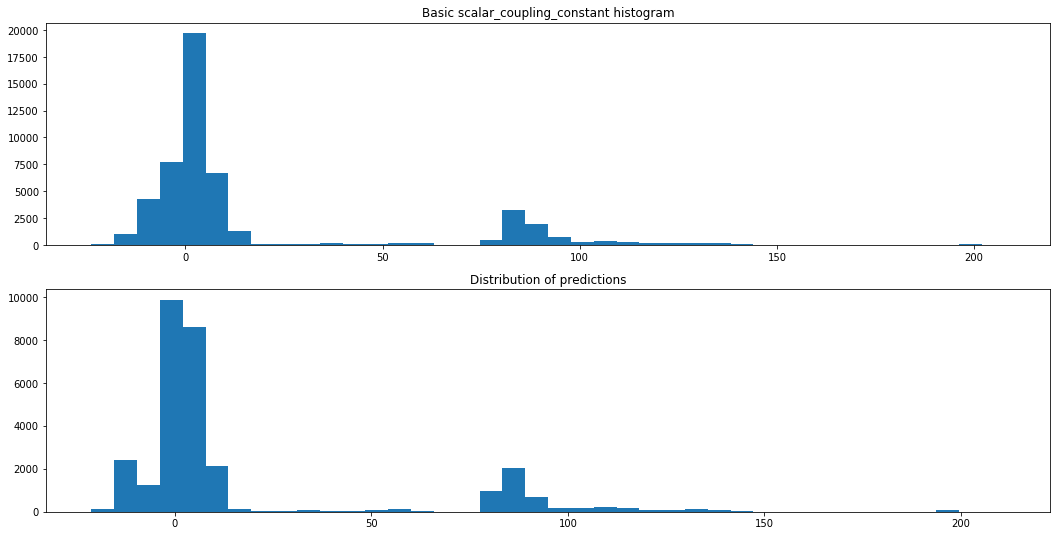

In [87]:
fig, ax = plt.subplots(figsize = (18, 9))
plt.subplot(2, 1, 1);
plt.hist(train['scalar_coupling_constant'], bins=40);
plt.title('Basic scalar_coupling_constant histogram');
plt.subplot(2, 1, 2);
plt.hist(result_dict_lgb['prediction'], bins=40);
plt.title('Distribution of predictions');

Training of type 0
Fold 1 started at Mon Mar 30 01:27:26 2020
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[31]	training's l1: 1.75458	valid_1's l1: 2.05617
Fold 2 started at Mon Mar 30 01:27:27 2020
Training until validation scores don't improve for 200 rounds
[500]	training's l1: 0.388783	valid_1's l1: 2.02991
[1000]	training's l1: 0.107844	valid_1's l1: 2.00383
[1500]	training's l1: 0.0348877	valid_1's l1: 1.99994
[2000]	training's l1: 0.0122561	valid_1's l1: 1.99837
[2500]	training's l1: 0.00526554	valid_1's l1: 1.99818
[3000]	training's l1: 0.00335518	valid_1's l1: 1.99813
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 0.00335518	valid_1's l1: 1.99813
Fold 3 started at Mon Mar 30 01:27:49 2020
Training until validation scores don't improve for 200 rounds
[500]	training's l1: 0.303631	valid_1's l1: 2.04849
[1000]	training's l1: 0.0819642	valid_1's l1: 2.03029
[1500]	training's l1: 0.0261685	valid_1's l1: 2.0

[3000]	training's l1: 0.00243052	valid_1's l1: 0.788323
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 0.00243052	valid_1's l1: 0.788323
Fold 3 started at Mon Mar 30 01:31:32 2020
Training until validation scores don't improve for 200 rounds
[500]	training's l1: 0.145932	valid_1's l1: 0.819073
[1000]	training's l1: 0.0392182	valid_1's l1: 0.811116
[1500]	training's l1: 0.0123223	valid_1's l1: 0.809166
[2000]	training's l1: 0.00489874	valid_1's l1: 0.808722
[2500]	training's l1: 0.00309328	valid_1's l1: 0.808632
[3000]	training's l1: 0.00244326	valid_1's l1: 0.808591
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 0.00244326	valid_1's l1: 0.808591
CV mean score: -0.2273, std: 0.0108.
Training of type 7
Fold 1 started at Mon Mar 30 01:32:01 2020
Training until validation scores don't improve for 200 rounds
[500]	training's l1: 0.0468478	valid_1's l1: 0.45752
[1000]	training's l1: 0.0140561	valid_1's l1: 0.452963
[1500]	training's l1: 0.0065689

,id,scalar_coupling_constant
0,4659076,16.064577787498322
1,4659077,132.804168136321181
2,4659078,6.223191278081856
3,4659079,132.584926943209240
4,4659080,15.095976946287783


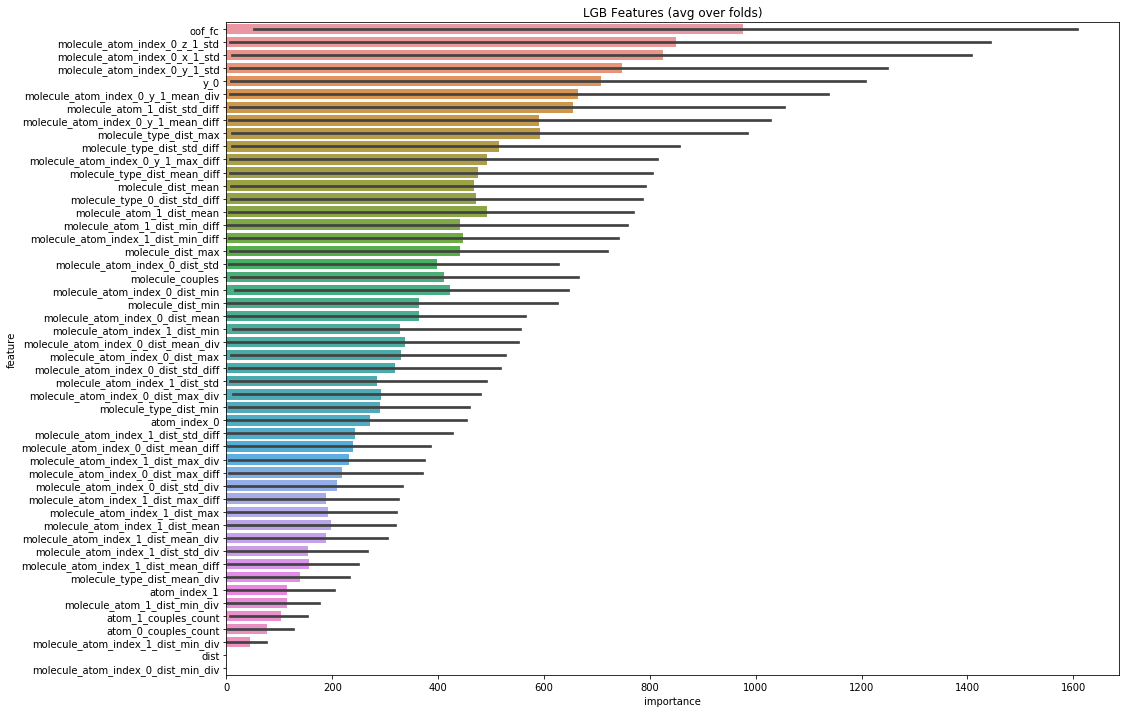

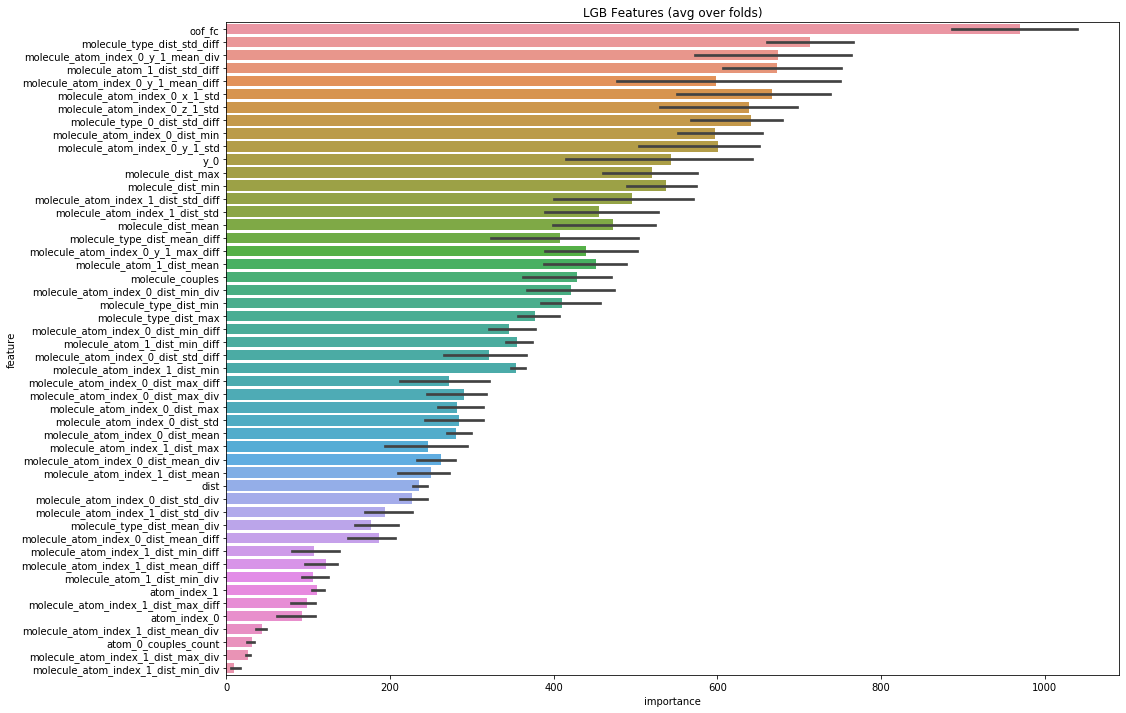

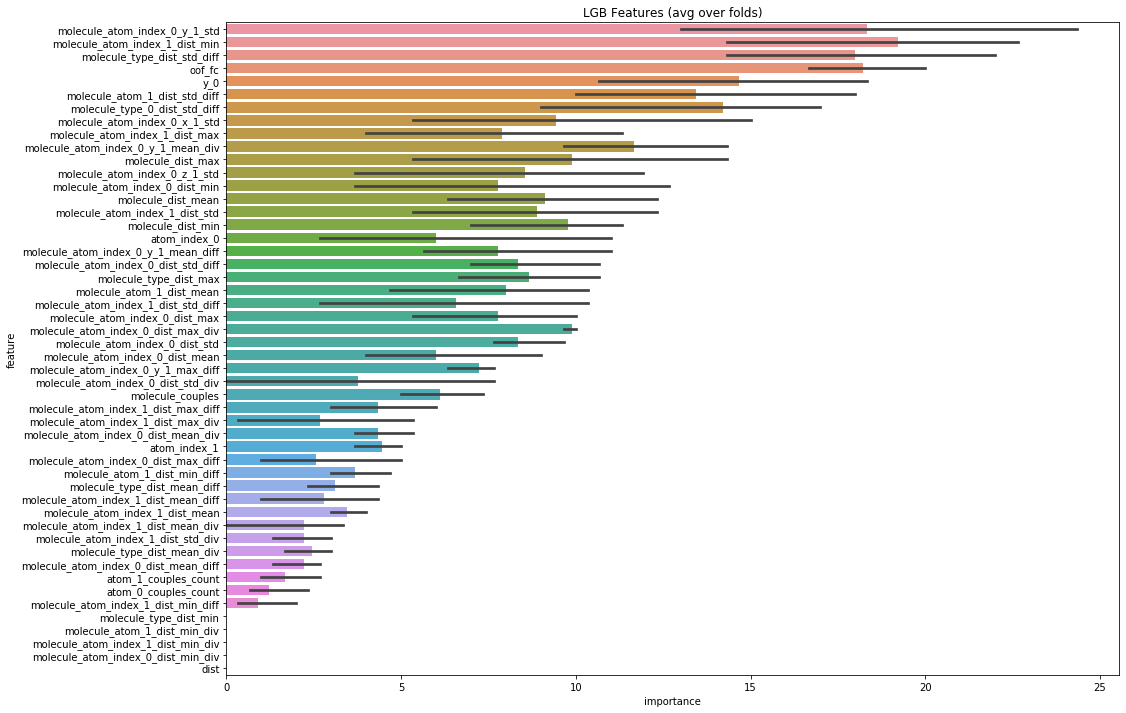

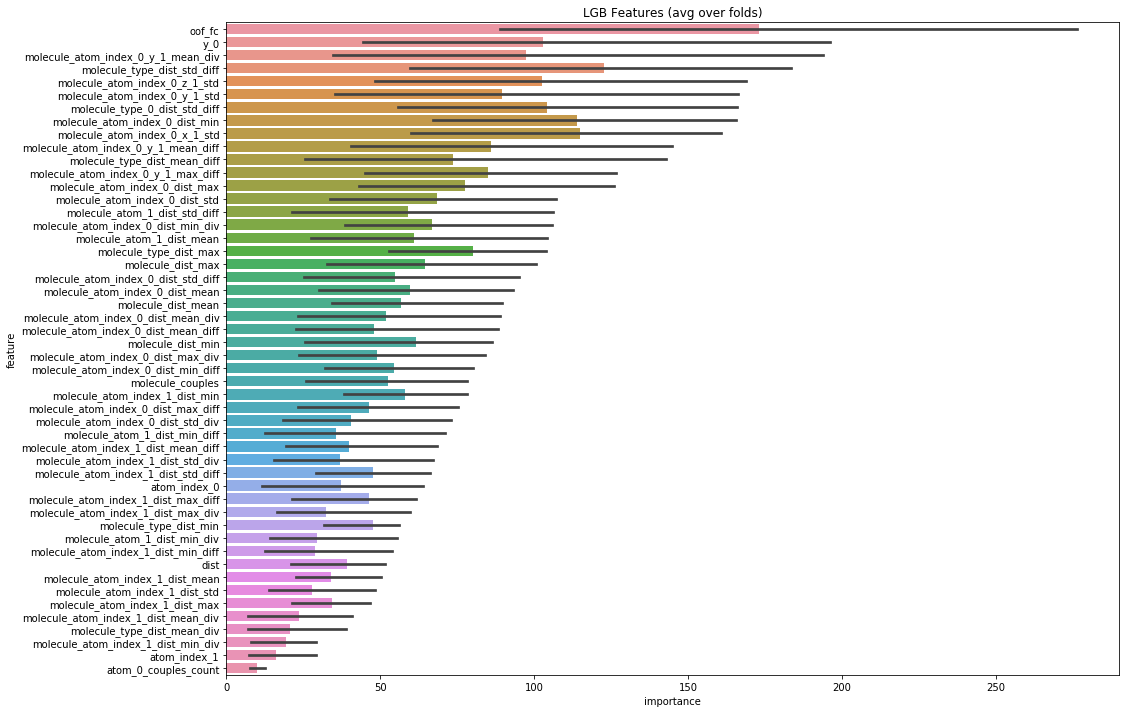

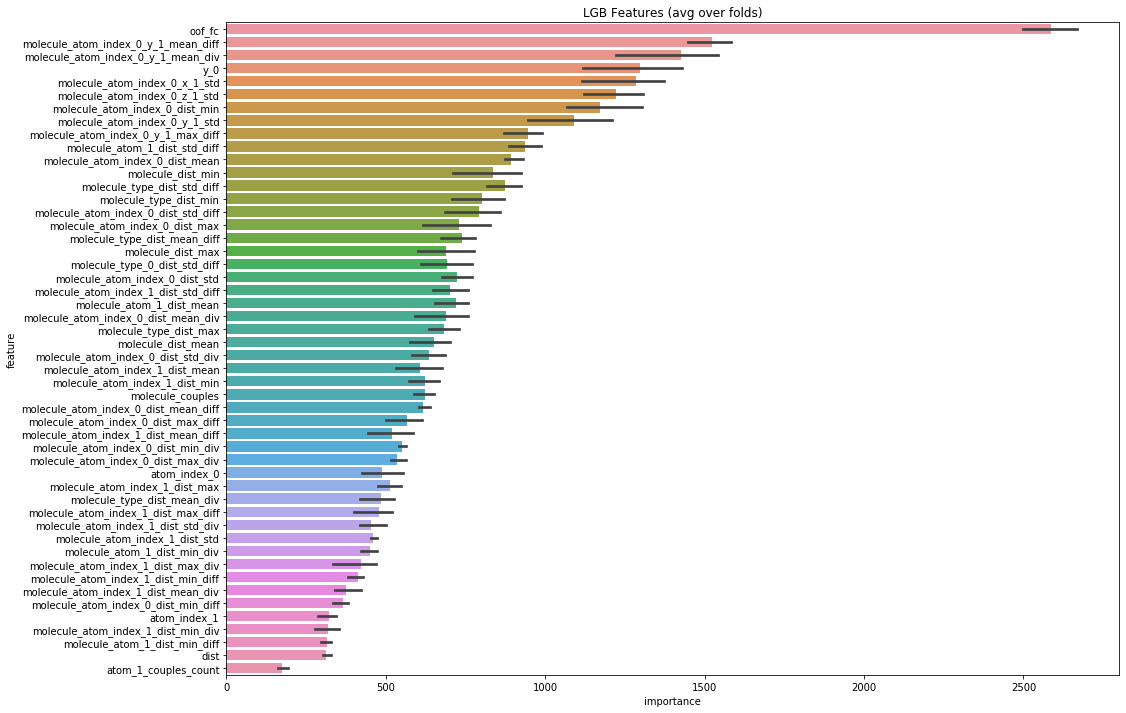

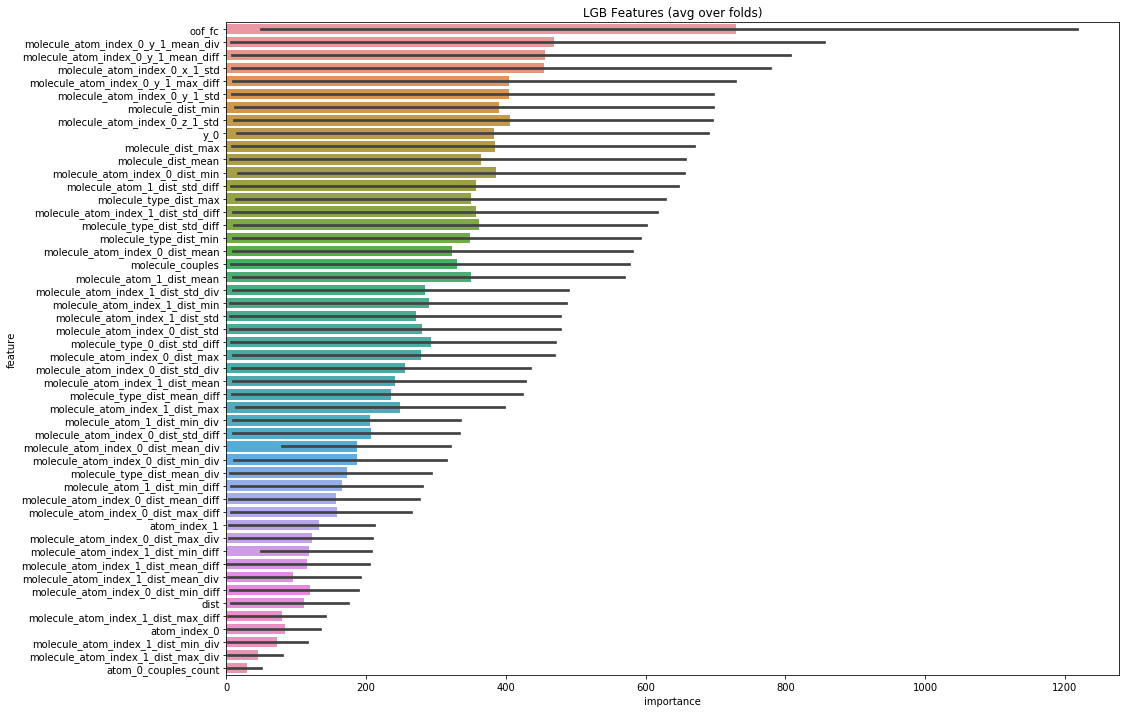

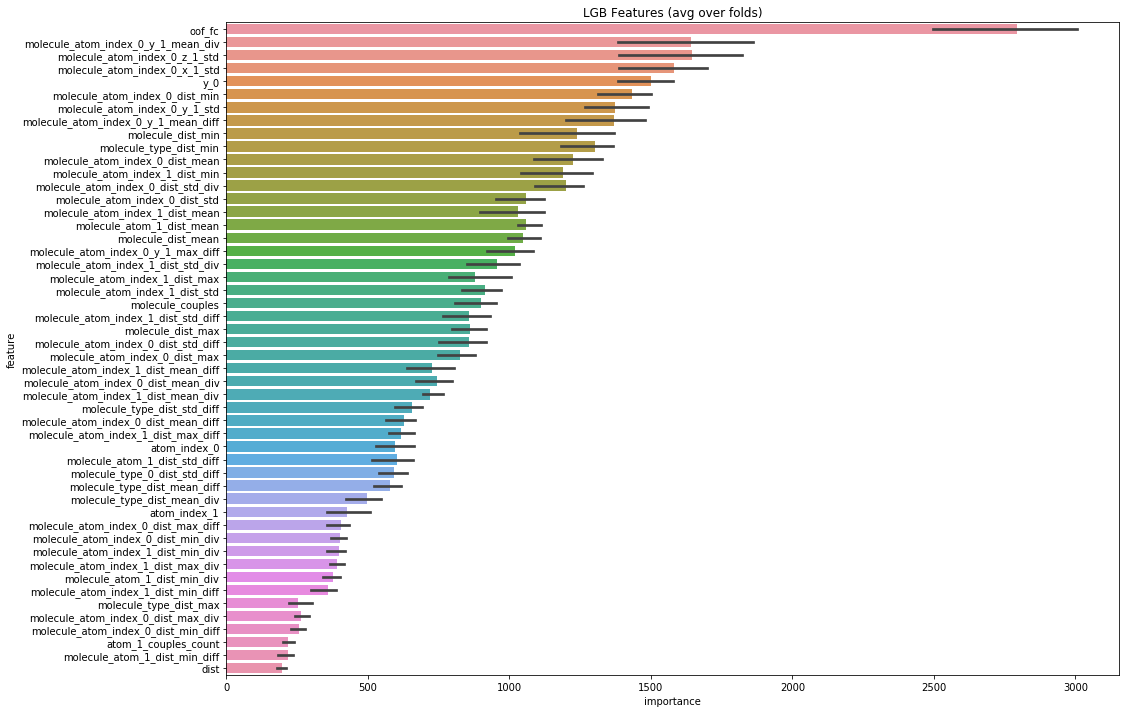

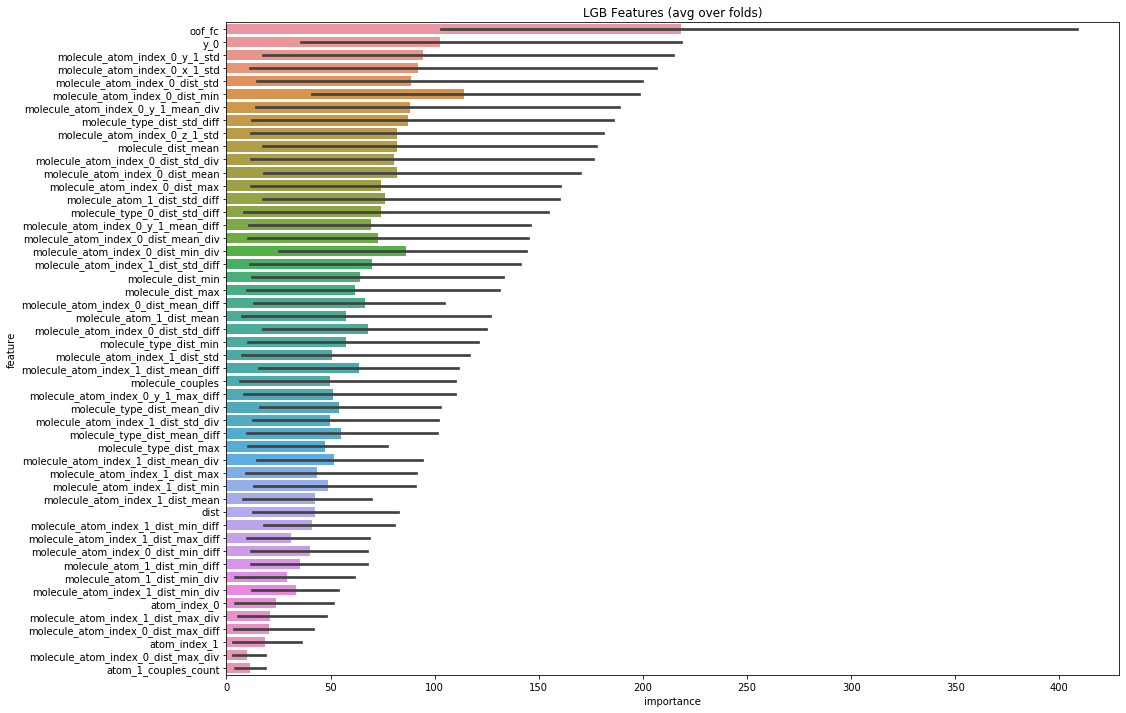

In [55]:
X_short = pd.DataFrame({'ind': list(X.index), 'type': X['type'].values, 'oof': [0] * len(X), 'target': y.values})
X_short_test = pd.DataFrame({'ind': list(X_test.index), 'type': X_test['type'].values, 'prediction': [0] * len(X_test)})
for t in X['type'].unique():
    print(f'Training of type {t}')
    X_t = X.loc[X['type'] == t]
    X_test_t = X_test.loc[X_test['type'] == t]
    y_t = X_short.loc[X_short['type'] == t, 'target']
    result_dict_lgb3 = train_model_regression(X=X_t, X_test=X_test_t, y=y_t, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=True,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=3000)
    X_short.loc[X_short['type'] == t, 'oof'] = result_dict_lgb3['oof']
    X_short_test.loc[X_short_test['type'] == t, 'prediction'] = result_dict_lgb3['prediction']
    
sub['scalar_coupling_constant'] = X_short_test['prediction']
sub.to_csv('submission_t.csv', index=False)
sub.head()

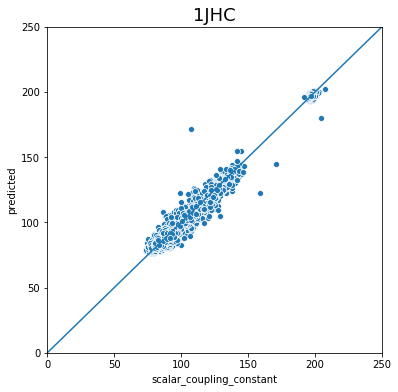

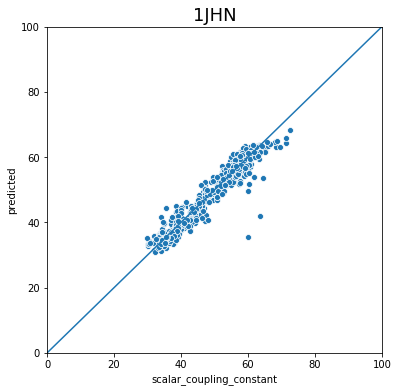

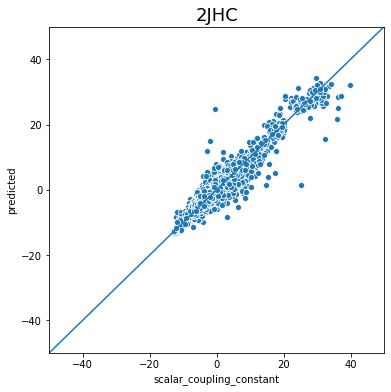

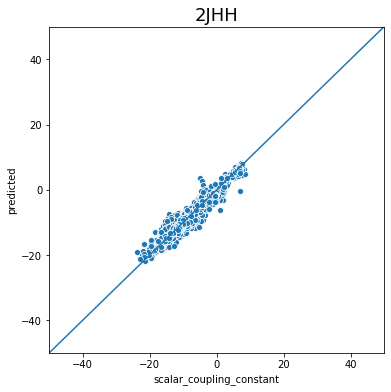

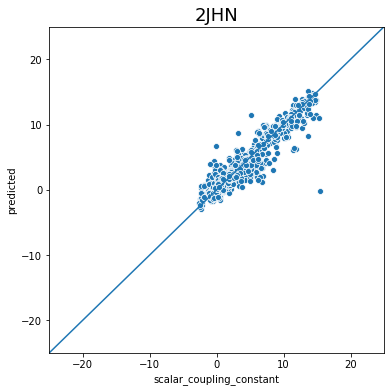

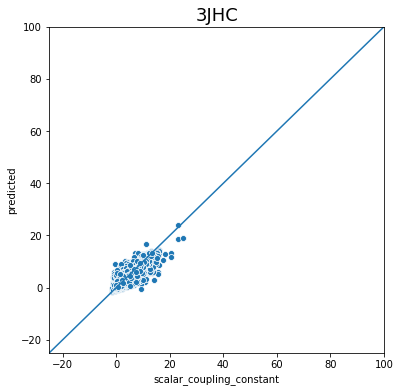

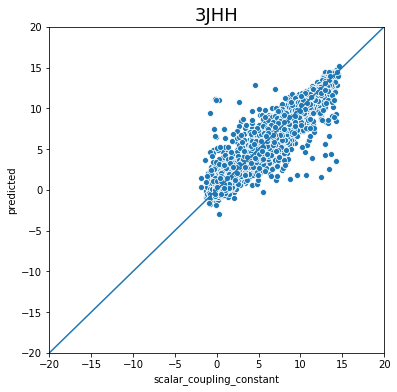

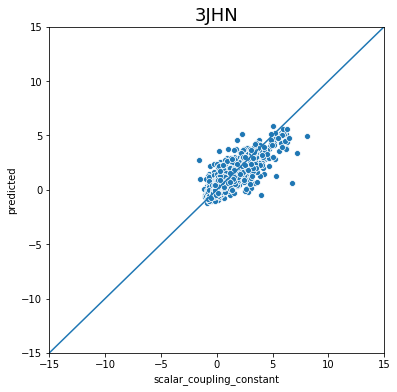

In [58]:
plot_data = pd.DataFrame(y)
plot_data.index.name = 'id'
plot_data['yhat'] = X_short['oof']
plot_data['type'] = lbl.inverse_transform(X['type'])

def plot_oof_preds(ctype, llim, ulim):
        plt.figure(figsize=(6,6))
        sns.scatterplot(x='scalar_coupling_constant',y='yhat',
                        data=plot_data.loc[plot_data['type']==ctype,
                        ['scalar_coupling_constant', 'yhat']]);
        plt.xlim((llim, ulim))
        plt.ylim((llim, ulim))
        plt.plot([llim, ulim], [llim, ulim])
        plt.xlabel('scalar_coupling_constant')
        plt.ylabel('predicted')
        plt.title(f'{ctype}', fontsize=18)
        plt.show()

plot_oof_preds('1JHC', 0, 250)
plot_oof_preds('1JHN', 0, 100)
plot_oof_preds('2JHC', -50, 50)
plot_oof_preds('2JHH', -50, 50)
plot_oof_preds('2JHN', -25, 25)
plot_oof_preds('3JHC', -25, 100)
plot_oof_preds('3JHH', -20, 20)
plot_oof_preds('3JHN', -15, 15)

In [60]:
import ase

In [61]:
structures.shape

(2358875, 6)

In [63]:
structures.head()


,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.0126981359,1.0858041578,0.0080009958
1,dsgdb9nsd_000001,1,H,0.0021504160,-0.0060313176,0.0019761204
2,dsgdb9nsd_000001,2,H,1.0117308433,1.4637511618,0.0002765748
3,dsgdb9nsd_000001,3,H,-0.5408150690,1.4475266138,-0.8766437152
4,dsgdb9nsd_000001,4,H,-0.5238136345,1.4379326443,0.9063972942


In [70]:
import random



In [71]:
from ase import Atoms
import ase.visualize



In [72]:
def view(molecule):
    # Select a molecule
    mol = structures[structures['molecule_name'] == molecule]
    
    # Get atomic coordinates
    xcart = mol.iloc[:, 3:].values
    
    # Get atomic symbols
    symbols = mol.iloc[:, 2].values
    
    # Display molecule
    system = Atoms(positions=xcart, symbols=symbols)
    print('Molecule Name: %s.' %molecule)
    print('Atoms: %s.' %symbols)
    return ase.visualize.view(system, viewer="x3d")

random_molecule = random.choice(structures['molecule_name'].unique())
view(random_molecule)

Molecule Name: dsgdb9nsd_052111.
Atoms: ['O' 'C' 'C' 'C' 'C' 'C' 'N' 'C' 'C' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H'
 'H' 'H'].


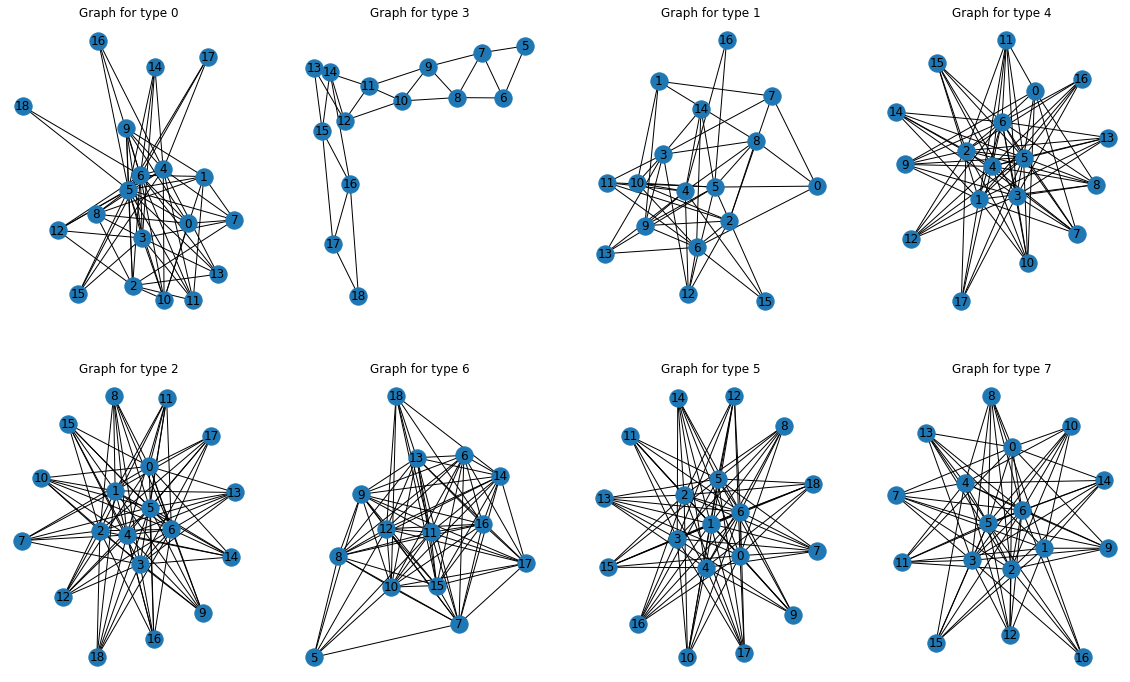

In [73]:
fig, ax = plt.subplots(figsize = (20, 12))
for i, t in enumerate(train['type'].unique()):
    train_type = train.loc[train['type'] == t]
    bad_atoms_0 = list(train_type['atom_index_0'].value_counts(normalize=True)[train_type['atom_index_0'].value_counts(normalize=True) < 0.01].index)
    bad_atoms_1 = list(train_type['atom_index_1'].value_counts(normalize=True)[train_type['atom_index_1'].value_counts(normalize=True) < 0.01].index)
    bad_atoms = list(set(bad_atoms_0 + bad_atoms_1))
    train_type = train_type.loc[(train_type['atom_index_0'].isin(bad_atoms_0) == False) & (train_type['atom_index_1'].isin(bad_atoms_1) == False)]
    G = nx.from_pandas_edgelist(train_type, 'atom_index_0', 'atom_index_1', ['scalar_coupling_constant'])
    plt.subplot(2, 4, i + 1);
    nx.draw(G, with_labels=True);
    plt.title(f'Graph for type {t}')